# IMPORTING LIBRARIES

In [1]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error


# Load and Prepare Data

In [2]:
# Load and Prepare Data
data = pd.read_csv('cleaned_data.csv')  # Replace with your actual file path

# Ensure the date column is in datetime format
data['date'] = pd.to_datetime(data['date'])

# Rename the columns to fit Prophet's requirements
data.rename(columns={'date': 'ds', 'price': 'y', 'vol.': 'volume'}, inplace=True)

# Prepare the DataFrame for Prophet
prophet_data = data[['ds', 'y', 'volume']]  # Adjust column names if needed
print(prophet_data.head())  # Check the first few rows


          ds      y    volume
0 2015-07-12  310.4  120700.0
1 2015-07-13  290.4  146850.0
2 2015-07-14  287.0   60620.0
3 2015-07-15  283.4   59580.0
4 2015-07-16  276.6  121320.0


In [3]:
# Define Holidays
covid_holidays = pd.DataFrame({
    'holiday': 'COVID_Holiday',
    'ds': pd.to_datetime(['2020-03-01', '2021-01-01', '2021-07-01']),
    'lower_window': 0,
    'upper_window': 1,  # Adjust this based on how long the effect lasts
})

# Split Data into Train and Test Sets
train_size = int(len(prophet_data) * 0.8)  # Use 80% for training
train, test = prophet_data[:train_size], prophet_data[train_size:]

# Display the sizes of the train and test sets
print(f'Training Set Size: {len(train)}')
print(f'Test Set Size: {len(test)}')

# Initialize and Fit the Model (Without Volume)
model = Prophet(
    holidays=covid_holidays,
    seasonality_mode='additive',          # Additive seasonality mode
    changepoint_prior_scale=0.02,          # Adjust flexibility for trend changes
    seasonality_prior_scale=0.49            # Adjust flexibility for seasonal component
)

# Fit the model
model.fit(train[['ds', 'y']])  # Use only price data


Training Set Size: 1716
Test Set Size: 430


11:18:26 - cmdstanpy - INFO - Chain [1] start processing
11:18:27 - cmdstanpy - INFO - Chain [1] done processing


In [4]:
# Make Predictions (Without Volume)
future = model.make_future_dataframe(periods=len(test))  # Predict the length of the test set
forecast = model.predict(future)

# Extract the predicted values for the test set
forecast_test = forecast[-len(test):]


# Evaluate Model Performance (Without Volume)
mae = mean_absolute_error(test['y'], forecast_test['yhat'])
mse = mean_squared_error(test['y'], forecast_test['yhat'])
rmse = mse ** 0.5
mape = mean_absolute_percentage_error(test['y'], forecast_test['yhat'])

# Print accuracy metrics
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {mape * 100}%')

Mean Absolute Error (MAE): 14094.316792599471
Mean Squared Error (MSE): 483722610.01791227
Root Mean Squared Error (RMSE): 21993.69477868401
Mean Absolute Percentage Error (MAPE): 36.862938846381944%


In [5]:
data.head()


,ds,y,open,high,low,volume,change %
0,2015-07-12,310.4,292.0,315.9,291.3,120700.0,6.33
1,2015-07-13,290.4,310.4,310.9,276.9,146850.0,-6.47
2,2015-07-14,287.0,290.4,297.0,285.2,60620.0,-1.17
3,2015-07-15,283.4,287.0,292.9,283.2,59580.0,-1.23
4,2015-07-16,276.6,283.4,290.8,273.3,121320.0,-2.41


In [6]:
# Count of missing values in the 'volume' column
missing_values_count = data['volume'].isnull().sum()
print(f'Missing values in volume column: {missing_values_count}')


Missing values in volume column: 0


11:18:27 - cmdstanpy - INFO - Chain [1] start processing
11:18:28 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error (MAE): 14081.629658093385
Mean Squared Error (MSE): 482881353.4378965
Root Mean Squared Error (RMSE): 21974.561507295122
Mean Absolute Percentage Error (MAPE): 36.82383097480496%


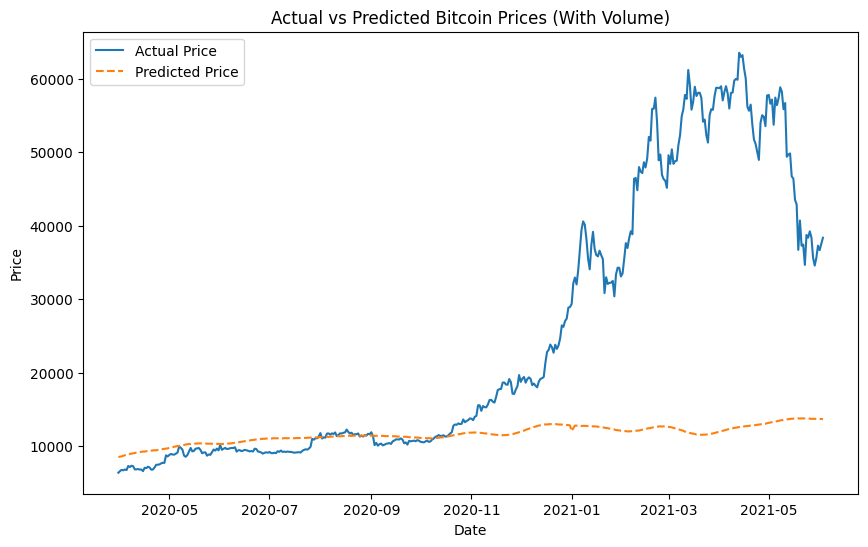

In [7]:
# Initialize and Fit the Model (With Volume Regressor)
model_with_volume = Prophet(
    holidays=covid_holidays,
    seasonality_mode='additive',           # Additive seasonality
    changepoint_prior_scale=0.02,          # Adjust trend flexibility
    seasonality_prior_scale=0.49           # Adjust seasonal flexibility
)

# Add 'volume' as a regressor
model_with_volume.add_regressor('volume')

# Fit the model
model_with_volume.fit(train[['ds', 'y', 'volume']])

# Make Predictions (With Volume)
future = model_with_volume.make_future_dataframe(periods=len(test))  # Predict the length of the test set

# Get the last available volume value and fill forward
last_volume = train['volume'].iloc[-1]
future['volume'] = last_volume  # Set all future volume values to the last known volume

# Make predictions
forecast_with_volume = model_with_volume.predict(future)

# Extract the predicted values for the test set
forecast_test_with_volume = forecast_with_volume[-len(test):]

# Evaluate Model Performance (With Volume)
mae_with_volume = mean_absolute_error(test['y'], forecast_test_with_volume['yhat'])
mse_with_volume = mean_squared_error(test['y'], forecast_test_with_volume['yhat'])
rmse_with_volume = mse_with_volume ** 0.5
mape_with_volume = mean_absolute_percentage_error(test['y'], forecast_test_with_volume['yhat'])

# Print accuracy metrics
print(f'Mean Absolute Error (MAE): {mae_with_volume}')
print(f'Mean Squared Error (MSE): {mse_with_volume}')
print(f'Root Mean Squared Error (RMSE): {rmse_with_volume}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_with_volume * 100}%')

# Visualize the Forecast (With Volume)
plt.figure(figsize=(10, 6))
plt.plot(test['ds'], test['y'], label='Actual Price')
plt.plot(test['ds'], forecast_test_with_volume['yhat'], label='Predicted Price', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted Bitcoin Prices (With Volume)')
plt.legend()
plt.show()


In [8]:
# Create lag features for the 'volume' column
train['lag_volume'] = train['volume'].shift(1)  # Lagged volume (1 day behind)
train['lag_volume_7'] = train['volume'].shift(7)  # Lagged volume (7 days behind)
train['lag_volume_30'] = train['volume'].shift(30)  # Lagged volume (30 days behind)

# Drop NaN values caused by lagging
train = train.dropna()  

# Now, fit the model using the lagged volume
model_with_lagged_volume = Prophet(
    holidays=covid_holidays,
    seasonality_mode='additive',
    changepoint_prior_scale=0.02,
    seasonality_prior_scale=0.49
)

# Add lagged volume features as regressors
model_with_lagged_volume.add_regressor('lag_volume')
model_with_lagged_volume.add_regressor('lag_volume_7')
model_with_lagged_volume.add_regressor('lag_volume_30')

# Fit the model
model_with_lagged_volume.fit(train[['ds', 'y', 'lag_volume', 'lag_volume_7', 'lag_volume_30']])

# Make Predictions (With Lagged Volume)
future = model_with_lagged_volume.make_future_dataframe(periods=len(test))  # Predict the length of the test set

# Fill future lag values (if needed) based on the last known values
future['lag_volume'] = train['lag_volume'].iloc[-1]  # Set to last known value for 1-day lag
future['lag_volume_7'] = train['lag_volume_7'].iloc[-1]  # Set to last known value for 7-day lag
future['lag_volume_30'] = train['lag_volume_30'].iloc[-1]  # Set to last known value for 30-day lag

# Make predictions
forecast_with_lagged_volume = model_with_lagged_volume.predict(future)

# Extract the predicted values for the test set
forecast_test_with_lagged_volume = forecast_with_lagged_volume[-len(test):]

# Evaluate Model Performance (With Lagged Volume)
mae_with_lagged_volume = mean_absolute_error(test['y'], forecast_test_with_lagged_volume['yhat'])
mse_with_lagged_volume = mean_squared_error(test['y'], forecast_test_with_lagged_volume['yhat'])
rmse_with_lagged_volume = mse_with_lagged_volume ** 0.5
mape_with_lagged_volume = mean_absolute_percentage_error(test['y'], forecast_test_with_lagged_volume['yhat'])

# Print accuracy metrics
print(f'Mean Absolute Error (MAE): {mae_with_lagged_volume}')
print(f'Mean Squared Error (MSE): {mse_with_lagged_volume}')
print(f'Root Mean Squared Error (RMSE): {rmse_with_lagged_volume}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_with_lagged_volume * 100}%')


C:\Users\Sufiyan Ahmed\AppData\Local\Temp\ipykernel_10624\3873704009.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['lag_volume'] = train['volume'].shift(1)  # Lagged volume (1 day behind)
C:\Users\Sufiyan Ahmed\AppData\Local\Temp\ipykernel_10624\3873704009.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['lag_volume_7'] = train['volume'].shift(7)  # Lagged volume (7 days behind)
C:\Users\Sufiyan Ahmed\AppData\Local\Temp\ipykernel_10624\3873704009.py:4: SettingWithCopyWarning: 
A value i

Mean Absolute Error (MAE): 14011.085297773316
Mean Squared Error (MSE): 478301637.6638415
Root Mean Squared Error (RMSE): 21870.10831394855
Mean Absolute Percentage Error (MAPE): 36.748407339880615%


In [9]:
# Create lag features for the 'volume' column
train['lag_volume'] = train['volume'].shift(1)  # Lagged volume (1 day behind)
train['lag_volume_7'] = train['volume'].shift(7)  # Lagged volume (7 days behind)
train['lag_volume_30'] = train['volume'].shift(30)  # Lagged volume (30 days behind)

# Drop NaN values caused by lagging
train = train.dropna()  

# Fit the model using the lagged volume
model_with_lagged_volume = Prophet(
    holidays=covid_holidays,
    seasonality_mode='additive',
    changepoint_prior_scale=0.02,
    seasonality_prior_scale=0.49
)

# Add lagged volume features as regressors
model_with_lagged_volume.add_regressor('lag_volume')
model_with_lagged_volume.add_regressor('lag_volume_7')
model_with_lagged_volume.add_regressor('lag_volume_30')

# Fit the model
model_with_lagged_volume.fit(train[['ds', 'y', 'lag_volume', 'lag_volume_7', 'lag_volume_30']])

# Make Predictions (With Lagged Volume)
future = model_with_lagged_volume.make_future_dataframe(periods=len(test))  # Predict the length of the test set

# Fill future lag values (if needed) based on the last known values
future['lag_volume'] = train['lag_volume'].iloc[-1]  # Set to last known value for 1-day lag
future['lag_volume_7'] = train['lag_volume_7'].iloc[-1]  # Set to last known value for 7-day lag
future['lag_volume_30'] = train['lag_volume_30'].iloc[-1]  # Set to last known value for 30-day lag

# Make predictions
forecast_with_lagged_volume = model_with_lagged_volume.predict(future)

# Extract the predicted values for the test set
forecast_test_with_lagged_volume = forecast_with_lagged_volume[-len(test):]

# Evaluate Model Performance (With Lagged Volume)
mae_with_lagged_volume = mean_absolute_error(test['y'], forecast_test_with_lagged_volume['yhat'])
mse_with_lagged_volume = mean_squared_error(test['y'], forecast_test_with_lagged_volume['yhat'])
rmse_with_lagged_volume = mse_with_lagged_volume ** 0.5
mape_with_lagged_volume = mean_absolute_percentage_error(test['y'], forecast_test_with_lagged_volume['yhat'])

# Print accuracy metrics
print(f'Mean Absolute Error (MAE): {mae_with_lagged_volume}')
print(f'Mean Squared Error (MSE): {mse_with_lagged_volume}')
print(f'Root Mean Squared Error (RMSE): {rmse_with_lagged_volume}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_with_lagged_volume * 100}%')


11:18:29 - cmdstanpy - INFO - Chain [1] start processing
11:18:29 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error (MAE): 13977.592267709062
Mean Squared Error (MSE): 475838949.7170682
Root Mean Squared Error (RMSE): 21813.73305321829
Mean Absolute Percentage Error (MAPE): 36.75493313654808%


In [10]:
# Calculate moving averages
train['moving_avg_7'] = train['volume'].rolling(window=7).mean()
train = train.dropna()  # Drop NaN values caused by moving average calculation


In [11]:
# Initialize and Fit the Model (With Moving Average and Lagged Volume)
model_with_moving_avg = Prophet(
    holidays=covid_holidays,
    seasonality_mode='additive',
    changepoint_prior_scale=0.02,
    seasonality_prior_scale=0.49
)

# Add lagged volume and moving average as regressors
model_with_moving_avg.add_regressor('lag_volume')
model_with_moving_avg.add_regressor('lag_volume_7')
model_with_moving_avg.add_regressor('lag_volume_30')
model_with_moving_avg.add_regressor('moving_avg_7')

# Fit the model
model_with_moving_avg.fit(train[['ds', 'y', 'lag_volume', 'lag_volume_7', 'lag_volume_30', 'moving_avg_7']])


11:18:30 - cmdstanpy - INFO - Chain [1] start processing
11:18:30 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
# Make Predictions (With Moving Average and Lagged Volume)
future = model_with_moving_avg.make_future_dataframe(periods=len(test))  # Predict the length of the test set

# Fill future lag values
future['lag_volume'] = train['lag_volume'].iloc[-1]  
future['lag_volume_7'] = train['lag_volume_7'].iloc[-1]  
future['lag_volume_30'] = train['lag_volume_30'].iloc[-1]  

# Fill future moving average
future['moving_avg_7'] = train['moving_avg_7'].iloc[-1]  # Use the last known moving average value

# Make predictions
forecast_with_moving_avg = model_with_moving_avg.predict(future)

# Evaluate the performance (similar to what you did before)


In [13]:
# Extract the predicted values for the test set
forecast_test_with_moving_avg = forecast_with_moving_avg[-len(test):]

# Evaluate Model Performance (With Moving Average and Lagged Volume)
mae_with_moving_avg = mean_absolute_error(test['y'], forecast_test_with_moving_avg['yhat'])
mse_with_moving_avg = mean_squared_error(test['y'], forecast_test_with_moving_avg['yhat'])
rmse_with_moving_avg = mse_with_moving_avg ** 0.5
mape_with_moving_avg = mean_absolute_percentage_error(test['y'], forecast_test_with_moving_avg['yhat'])

# Print accuracy metrics
print(f'Mean Absolute Error (MAE): {mae_with_moving_avg}')
print(f'Mean Squared Error (MSE): {mse_with_moving_avg}')
print(f'Root Mean Squared Error (RMSE): {rmse_with_moving_avg}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_with_moving_avg * 100}%')


Mean Absolute Error (MAE): 13997.096238287913
Mean Squared Error (MSE): 477532239.04459226
Root Mean Squared Error (RMSE): 21852.511046664462
Mean Absolute Percentage Error (MAPE): 36.72638185470321%


11:18:59 - cmdstanpy - INFO - Chain [1] start processing
11:19:01 - cmdstanpy - INFO - Chain [1] done processing


MAE: 186.82940129913266


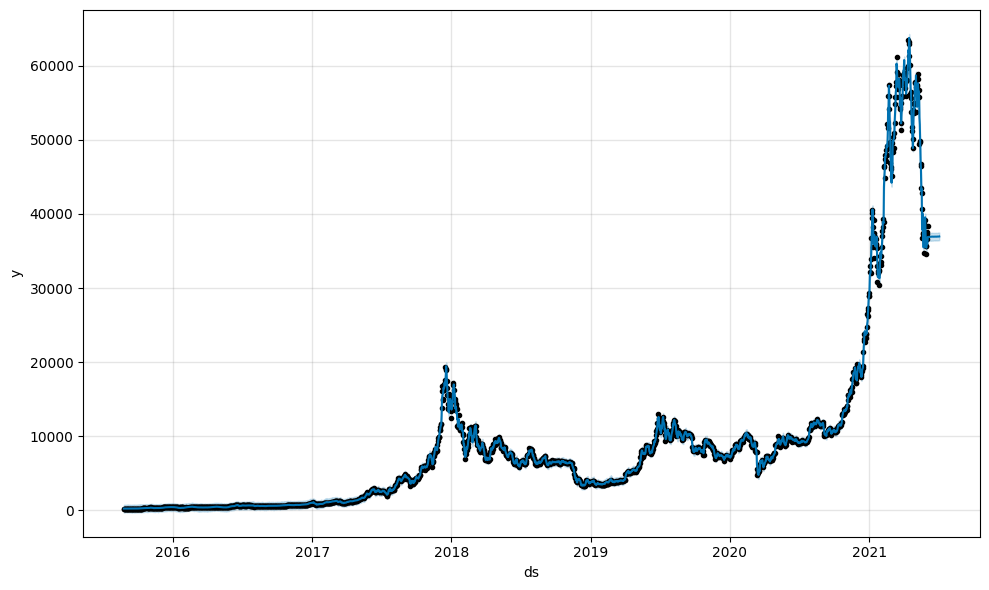

In [14]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error

# Load the dataset
df = pd.read_csv('cleaned_data.csv')

# Convert date to datetime format
df['date'] = pd.to_datetime(df['date'])
df = df.rename(columns={'date': 'ds', 'price': 'y'})

# Calculate Moving Averages
df['SMA_10'] = df['y'].rolling(window=10).mean()
df['SMA_30'] = df['y'].rolling(window=30).mean()
df['SMA_45'] = df['y'].rolling(window=45).mean()
df['EMA_10'] = df['y'].ewm(span=10, adjust=False).mean()
df['EMA_30'] = df['y'].ewm(span=30, adjust=False).mean()
df['EMA_45'] = df['y'].ewm(span=45, adjust=False).mean()

# Create Lag Features
df['lag_1'] = df['y'].shift(1)
df['lag_7'] = df['y'].shift(7)
df['lag_30'] = df['y'].shift(30)

# Drop rows with NaN values resulting from rolling and lag calculations
df.dropna(inplace=True)

# Initialize the Prophet model
model = Prophet(changepoint_prior_scale=0.1, seasonality_mode='multiplicative')

# Add moving averages, lag features, and volume as regressors
model.add_regressor('SMA_10')
model.add_regressor('SMA_30')
model.add_regressor('SMA_45')
model.add_regressor('EMA_10')
model.add_regressor('EMA_30')
model.add_regressor('EMA_45')
model.add_regressor('lag_1')
model.add_regressor('lag_7')
model.add_regressor('lag_30')
model.add_regressor('vol.')  # Assuming 'vol.' is the name of the volume column in your data

# Fit the model
model.fit(df)

# Prepare future data for forecasting
future = model.make_future_dataframe(periods=30)

# Merge future with moving averages and lag features
# Use the latest known values for moving averages and lag features for future dates
future = future.merge(df[['ds', 'SMA_10', 'SMA_30', 'SMA_45', 'EMA_10', 'EMA_30', 'EMA_45', 'lag_1', 'lag_7', 'lag_30', 'vol.']], on='ds', how='left')

# Forward fill to handle any NaN values
future.fillna(method='ffill', inplace=True)

# Ensure there are no NaN values before prediction
if future.isnull().values.any():
    print("NaN values found in future DataFrame.")
    print(future[future.isnull().any(axis=1)])  # Display rows with NaN values
else:
    # Make predictions
    forecast = model.predict(future)

    # Calculate MAE
    forecasted_values = forecast[['ds', 'yhat']].merge(df[['ds', 'y']], on='ds', how='left')
    
    # Drop rows with NaN in the merged DataFrame for MAE calculation
    forecasted_values.dropna(inplace=True)
    
    mae = mean_absolute_error(forecasted_values['y'], forecasted_values['yhat'])
    print(f'MAE: {mae}')

    # Optionally, visualize the results
    model.plot(forecast)


# Feature Importance (with splitting train and test)

11:20:00 - cmdstanpy - INFO - Chain [1] start processing


Feature Importance from Random Forest:
   Feature  Importance
6   lag_1    0.931162
3  EMA_10    0.040022
2  SMA_45    0.009488
0  SMA_10    0.006227
1  SMA_30    0.003697
4  EMA_30    0.003542
5  EMA_45    0.003476
9    vol.    0.001143
8  lag_30    0.000688
7   lag_7    0.000557


11:20:00 - cmdstanpy - INFO - Chain [1] done processing


MAE after feature selection: 206.09108260479414


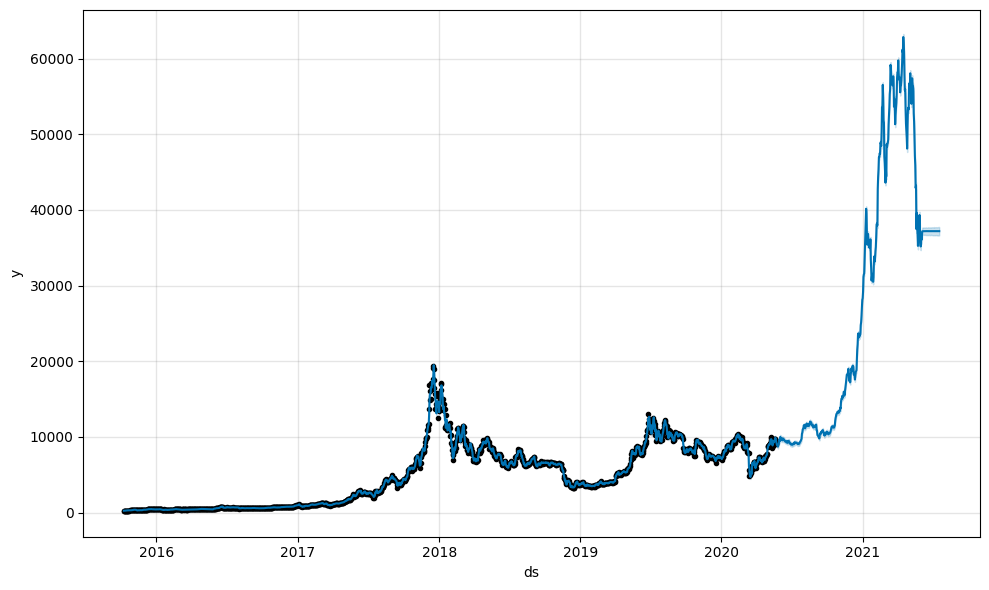

In [16]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv('cleaned_data.csv')

# Convert date to datetime format
df['date'] = pd.to_datetime(df['date'])
df = df.rename(columns={'date': 'ds', 'price': 'y'})

# Calculate Moving Averages
df['SMA_10'] = df['y'].rolling(window=10).mean()
df['SMA_30'] = df['y'].rolling(window=30).mean()
df['SMA_45'] = df['y'].rolling(window=45).mean()
df['EMA_10'] = df['y'].ewm(span=10, adjust=False).mean()
df['EMA_30'] = df['y'].ewm(span=30, adjust=False).mean()
df['EMA_45'] = df['y'].ewm(span=45, adjust=False).mean()

# Create Lag Features
df['lag_1'] = df['y'].shift(1)
df['lag_7'] = df['y'].shift(7)
df['lag_30'] = df['y'].shift(30)

# Drop rows with NaN values resulting from rolling and lag calculations
df.dropna(inplace=True)

# Prepare features and target
features = df[['SMA_10', 'SMA_30', 'SMA_45', 'EMA_10', 'EMA_30', 'EMA_45', 'lag_1', 'lag_7', 'lag_30', 'vol.']]
target = df['y']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, shuffle=False)

# Train a Random Forest model for feature importance
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importance
importance_df = pd.DataFrame({
    'Feature': features.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Feature Importance from Random Forest:\n", importance_df)

# Select important features (you can adjust the threshold as needed)
selected_features = importance_df[importance_df['Importance'] > 0].Feature.tolist()  # Keep features with non-zero importance

# Initialize the Prophet model
model = Prophet(changepoint_prior_scale=0.1, seasonality_mode='additive')

# Add selected features as regressors
for feature in selected_features:
    model.add_regressor(feature)

# Fit the model with the training data
train_df = df.iloc[X_train.index].copy()  # Use original df to align dates with features
model.fit(train_df)

# Prepare future data for forecasting with the testing data
future = model.make_future_dataframe(periods=len(X_test))

# Merge future with selected features
future = future.merge(df[['ds'] + selected_features], on='ds', how='left')

# Forward fill to handle any NaN values
future.fillna(method='ffill', inplace=True)

# Ensure there are no NaN values before prediction
if future.isnull().values.any():
    print("NaN values found in future DataFrame.")
else:
    # Make predictions
    forecast = model.predict(future)

    # Calculate MAE on the test set
    forecasted_values = forecast[['ds', 'yhat']].merge(df[['ds', 'y']], on='ds', how='left')
    
    # Drop rows with NaN in the merged DataFrame for MAE calculation
    forecasted_values.dropna(inplace=True)
    
    mae = mean_absolute_error(forecasted_values['y'], forecasted_values['yhat'])
    print(f'MAE after feature selection: {mae}')

    # Optionally, visualize the results
    model.plot(forecast)


# After selection of most Improtant Feature (Lag_1).

11:22:05 - cmdstanpy - INFO - Chain [1] start processing
11:22:05 - cmdstanpy - INFO - Chain [1] done processing


MAE after using lag_1 only: 297.08916171202986


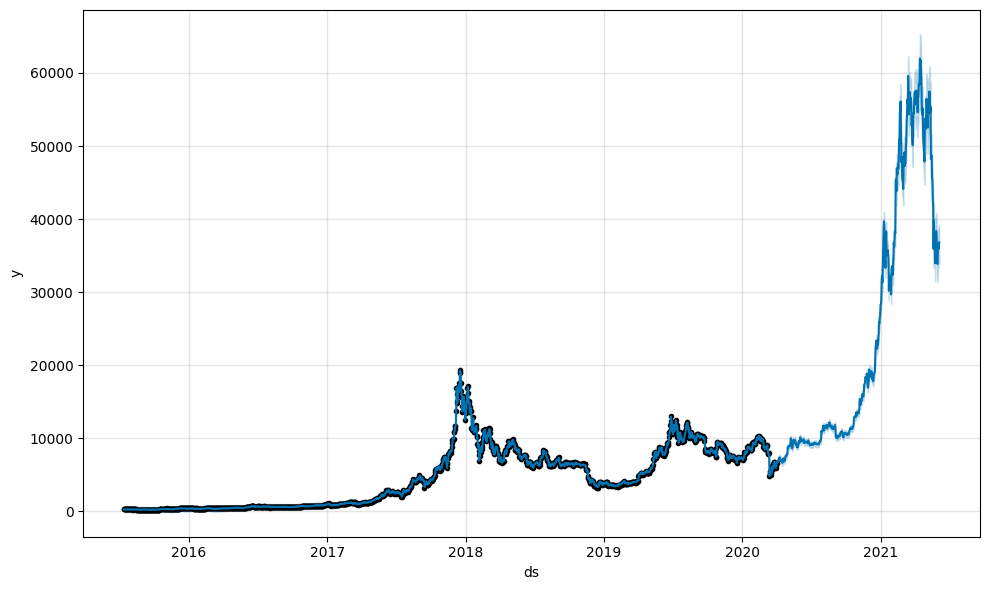

In [17]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv('cleaned_data.csv')

# Convert date to datetime format
df['date'] = pd.to_datetime(df['date'])
df = df.rename(columns={'date': 'ds', 'price': 'y'})

# Create Lag Features
df['lag_1'] = df['y'].shift(1)

# Drop rows with NaN values resulting from lag calculations
df.dropna(inplace=True)

# Prepare features and target
features = df[['lag_1']]
target = df['y']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, shuffle=False)

# Initialize the Prophet model
model = Prophet(changepoint_prior_scale=0.1, seasonality_mode='multiplicative')

# Add lag_1 as a regressor
model.add_regressor('lag_1')

# Fit the model with the training data
train_df = df.iloc[X_train.index].copy()  # Use original df to align dates with features
model.fit(train_df)

# Prepare future data for forecasting with the testing data
future = model.make_future_dataframe(periods=len(X_test))

# Merge future with the lag_1 feature
future = future.merge(df[['ds', 'lag_1']], on='ds', how='left')

# Forward fill to handle any NaN values
future.fillna(method='ffill', inplace=True)

# Ensure there are no NaN values before prediction
if future.isnull().values.any():
    print("NaN values found in future DataFrame.")
else:
    # Make predictions
    forecast = model.predict(future)

    # Calculate MAE on the test set
    forecasted_values = forecast[['ds', 'yhat']].merge(df[['ds', 'y']], on='ds', how='left')
    
    # Drop rows with NaN in the merged DataFrame for MAE calculation
    forecasted_values.dropna(inplace=True)
    
    mae = mean_absolute_error(forecasted_values['y'], forecasted_values['yhat'])
    print(f'MAE after using lag_1 only: {mae}')

    # Optionally, visualize the results
    model.plot(forecast)
